# Ужасы линейной регрессии

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
np.random.seed(42)



In [ ]:
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path='../.env')
data_path = os.getenv('LOCAL_DATA')

sns.set(style='whitegrid', context='talk')

# Разминка
1) Какие признаки может обработать линейная регрессия?
2) Почему нет понятия полиномиальных моделей?
3) Вам дан набор данных из 8 элементов. Вы используете стохастический градиентный спуск с батчем 8. Сколько шагов нужно сделать, чтобы пройти весь набор данных?
4) Вам нужно предсказать, к какой категории относится товар. Всего категорий 100. Как лучше решать такую задачу - через регрессию или классификацию?
5) Вам нужно предсказать, в каком часу была сделана покупка некоторого товара. Вы решили использовать для этого регрессию. Расскажите, как вы будете решать эту задачу. Как вы сформируете таргет? Как будете выдавать предсказания на инференсе?
6) Как выглядит точное решение задачи линейной регрессии (нормальная форма)?

# База
Напомню, что линейная регрессия - это модель следующего вида:
    $$a(x) = \langle w, x \rangle + w_0$$,
    где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. 
Обучить линейную регрессию - значит найти $w$ и $w_0$., минимизирующие разницу между предсказанными значениями  $y'$ и  $y$.

# Ловушки в данных

Рассмотрим набор данных, состоящий из 2 разных предикторов и четырех таргетов. Этот набор специально создан, чтобы показать важность анализа данных даже в, казалось бы, простой ситуации. Построим 4 разные модели по парам (x123, y1), (x123, y2),(x123, y3), (x4, y4).

In [3]:
quartet_df = pd.read_csv(f"{data_path}/Anscombe_quartet_data.csv")

In [6]:
quartet_df

,x123,y1,y2,y3,x4,y4
0,10.0,8.04,9.14,7.46,8.0,6.58
1,8.0,6.95,8.14,6.77,8.0,5.76
2,13.0,7.58,8.74,12.74,8.0,7.71
3,9.0,8.81,8.77,7.11,8.0,8.84
4,11.0,8.33,9.26,7.81,8.0,8.47
5,14.0,9.96,8.10,8.84,8.0,7.04
6,6.0,7.24,6.13,6.08,8.0,5.25
7,4.0,4.26,3.10,5.39,19.0,12.50
8,12.0,10.84,9.13,8.15,8.0,5.56
9,7.0,4.82,7.26,6.42,8.0,7.91


Для начала рассмотрим значения корреляций между признаками и таргетами

In [4]:
def corrplot(d: pd.DataFrame) -> None:
  corr = d.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  figsize = (min(d.shape[1], 11), min(d.shape[1], 9))
  f, ax = plt.subplots(figsize=figsize)
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

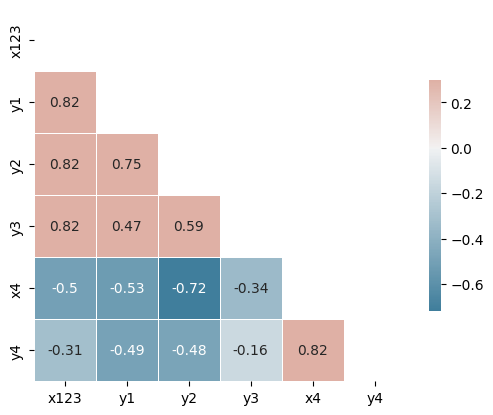

In [5]:
corrplot(quartet_df)

Как видно, корреляции одинаковы. Однако, если построить модели и графики предсказаний, результаты будут знгачительно отличаться.
ЭТакже выведем значения коэффициентов модели.

**Задание**: Постройте линейные модели для каждого из наборов данных, не смотря на графики. Отличаются ли модели?

In [10]:
# Anscombe 1
x = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y1'])
model_1 = LinearRegression().fit(x, y)
y_pred = model_1.predict(x)
r_sq = model_1.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_1.intercept_}")
print(f"slope: {model_1.coef_}")


coefficient of determination: 0.6665424595087748
intercept: 3.0000909090909094
slope: [0.50009091]


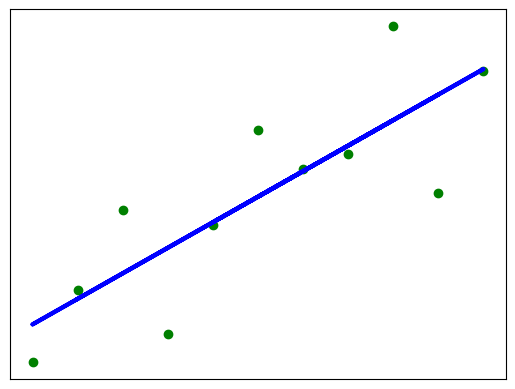

In [11]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [12]:
# Anscombe 2
x = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y2'])
model_1 = LinearRegression().fit(x, y)
y_pred = model_1.predict(x)
r_sq = model_1.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_1.intercept_}")
print(f"slope: {model_1.coef_}")

coefficient of determination: 0.6662420337274844
intercept: 3.00090909090909
slope: [0.5]


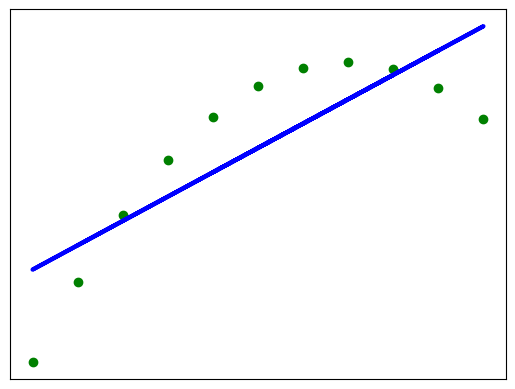

In [13]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [14]:
# Anscombe 3

x = np.array(quartet_df['x123']).reshape((-1, 1))
y = np.array(quartet_df['y3'])
model_1 = LinearRegression().fit(x, y)
y_pred = model_1.predict(x)
r_sq = model_1.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_1.intercept_}")
print(f"slope: {model_1.coef_}")

coefficient of determination: 0.6663240410665592
intercept: 3.002454545454545
slope: [0.49972727]


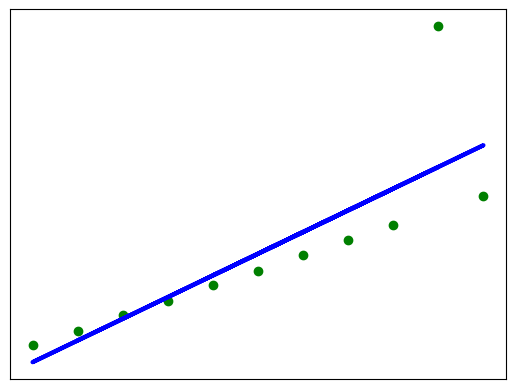

In [15]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [16]:
# Anscombe 4

x = np.array(quartet_df['x4']).reshape((-1, 1))
y = np.array(quartet_df['y4'])
model_1 = LinearRegression().fit(x, y)
y_pred = model_1.predict(x)
r_sq = model_1.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model_1.intercept_}")
print(f"slope: {model_1.coef_}")


coefficient of determination: 0.6667072568984653
intercept: 3.0017272727272726
slope: [0.49990909]


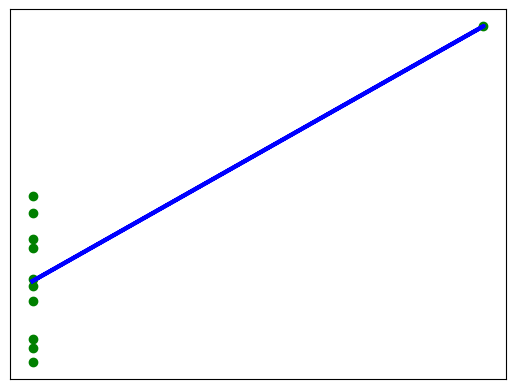

In [17]:
plt.scatter(x, y, color="green")
plt.plot(x, y_pred, color="blue", linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

Как видно, все эти зависимости имеют разную природу, но при этом порождают модели с практически одинаковыми параметрами. Таким образом, чрезвычайно важно проводить достаточно объемный EDA.
Датасте же - известный набор [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)

# Положения линейной регрессии
Далее рассмотрим некоторые положения линейной регрессии, которые задают границы ее применимости (а также что бывает, когда они нарушаются).

**Линейность**: взаимосвязь между зависимыми и независимыми переменными линейна.

**Независимость**: Наблюдения независимы друг от друга.

**Гомоскедастичность**: дисперсия ошибок постоянна на всех уровнях независимых переменных.

**Нормальность**: ошибки подчиняются нормальному распределению.

**Нет мультиколлинеарности**: независимые переменные не сильно коррелируют друг с другом.

**Нет эндогенности**: между ошибками и независимыми переменными нет связи.

## Нелинейность

Рассмотрим набор данных Bluegills.
В 1981 году n = 78 [cинежаберных солнечников](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BD%D0%B5%D0%B6%D0%B0%D0%B1%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D1%81%D0%BE%D0%BB%D0%BD%D0%B5%D1%87%D0%BD%D0%B8%D0%BA) были случайным образом отобраны из озера Мэри в Миннесоте (Кук и Вайсберг, 1999):
* Длина (в мм) рыбы
* Возраст (в годах) рыбы


In [18]:
df = pd.read_csv(f"{data_path}/bluegills.txt", sep="\t")

In [19]:
df

,age,length
0,1,67
1,1,62
2,2,109
3,2,83
4,2,91
...,...,...
73,6,170
74,4,160
75,5,180
76,4,160


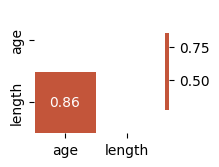

In [20]:
corrplot(df)

Постройте график длины рыбы от возраста 

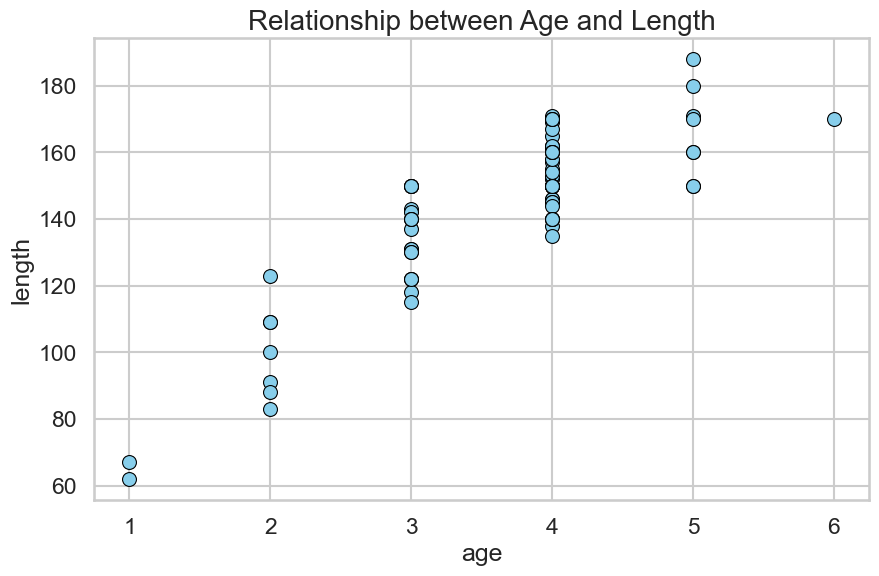

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='length', data=df, s=100, color='skyblue', edgecolor='black')

plt.title('Relationship between Age and Length', fontsize=20)

plt.show()

График позволяет предположить, что в данных наблюдается положительная динамика. Неудивительно, что с увеличением возраста рыб их длина имеет тенденцию к увеличению. Однако эта тенденция не выглядит вполне линейной. Кажется, что отношения слегка искривлены.

Один из способов моделирования кривизны этих данных — сформулировать «полиномиальную модель второго порядка»:

$ Y=\beta_0+ \sum_i (\alpha_i  X_i^2) + \sum_i (\beta_i  X_i) + \sum_{j \neq i} (\gamma_{ij}  X_i X_j) + \epsilon $

Сделать это просто, введя в данные полиномиальные признаки (PolynomialFeatures) и обучив обычную линейную модель.

**Задание**: Обучите обычную и полиномиальную регрессии на рыбах. Постройте графики предсказаний. 
**Доп.задание**: Определите MSE для двух моделей.

In [30]:
X = df['age'].values.reshape((-1, 1))
y = df['length'].values
model_basic =  LinearRegression().fit(X, y)
y_basic = model_basic.predict(X)

In [31]:
degree = 2  # Set the polynomial degree
poly_features =  PolynomialFeatures(degree=degree) # Instantiate polynomial features
X_poly = poly_features.fit_transform(X) # call fit_transfrom of poly_features on age

model_poly = LinearRegression().fit(X_poly, y)
# fit model on processed data

y_poly = model_poly.predict(X_poly)

In [32]:
print(f"coefficient of determination of linear model: {model_basic.score(X, y)}")
print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")

coefficient of determination of linear model: 0.7348821471782518
coefficient of determination of polynomial model: 0.8011378030846004


In [35]:
print(f"MSE of linear model: {mean_squared_error(y, y_basic)}")
print(f"MSE of polynomial model: {mean_squared_error(y, y_poly)}")

MSE of linear model: 152.47226648794904
MSE of polynomial model: 114.36789171210624


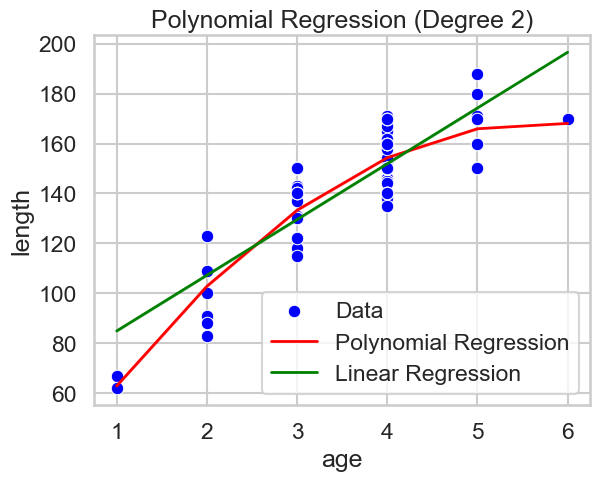

In [36]:
sns.scatterplot(df,x="age", y="length", label='Data', color='blue')
sns.lineplot(x=df["age"], y=y_poly, label='Polynomial Regression', color='red', linewidth=2)
sns.lineplot(x=df["age"], y=y_basic, label='Linear Regression', color='green', linewidth=2)
plt.xlabel('age')
plt.ylabel('length')
plt.legend()
plt.title(f'Polynomial Regression (Degree {degree})')
plt.show()

**Задание**: Постройте модель с фичами высокой степени.

In [41]:
degree =  15  # Set the polynomial degree

poly_features =  PolynomialFeatures(degree=degree) # Instantiate polynomial features
X_poly = poly_features.fit_transform(X) # call fit_transfrom of poly_features on age

model_poly = LinearRegression().fit(X_poly, y)
# fit model on processed data

y_poly = model_poly.predict(X_poly)

In [42]:
print(f"coefficient of determination of polynomial model: {model_poly.score(X_poly, y)}")

coefficient of determination of polynomial model: 0.8035456295590081


In [43]:
print(f"MSE of polynomial model: {mean_squared_error(y, y_poly)}")

MSE of polynomial model: 112.98312355728314


**Задание**: Постройте модель для наборов Anscombe 1 и Anscombe 2. Напишите, какие степени полинома подойдут лучше всего.

**Задание со звездочкой**: Постройте модель с использованием другого базиса, не полиномиального. Проиллюстрируйте ее применение на примерах из практики.

## Выбросы
Как мы уже видели, выбросы могут сильно влиять на предсказания линейной модели. Даже один выброс может нарушить одно из условий линейной регрессии. К счастью, существует много способов с ними бороться.
Простейший вариант - использовать не MSE, а MAE. Почему?
Однако есть и более сложные варианты. Например, комбинация MSE и MAE дает **HuberLoss**.

Другой робастный вариант - **Theil-Sen regression**. Этот метод строит медиану наклона модели между всеми парами наблюдений. Проблема этого метода в том, что для больших наборов данных вычислительная сложность метода становится слишком большой.

Третий метод: **RANSAC**. В этом методе итеративно берутся подвыборки заданного размера, строятся модели и считаются расстояния от предсказания до реальной точки. Далее точки, для которых расстояние меньше некоторой границы, считаются доверенными. На этих данных обучается новая модель-кандидат. В качестве финальной используется лучший кандидат. Однако данный метод подходит только для моделей, которые не требуют очень большого количества данных.

Рассмотрим синтетические данные. Пусть это будут синусоидальные данные, но некоторые наблюдения будут "испорчены"

In [44]:
X = np.random.uniform(0, 1.5, size=300)
y = np.sin(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=X.shape)
X = X.reshape(-1,1)

X_test = np.random.uniform(0, 1.5, size=300) 
y_test = np.sin(1.5 * np.pi * X_test) + np.random.normal(scale=0.1, size=X_test.shape)
X_test = X_test.reshape(-1,1)

y_errors = y.copy()
y_errors[::5] = 3

X_errors = X.copy()
X_errors[::5] = 3

y_errors_large = y.copy()
y_errors_large[::5] = 10

X_errors_large = X.copy()
X_errors_large[::5] = 10

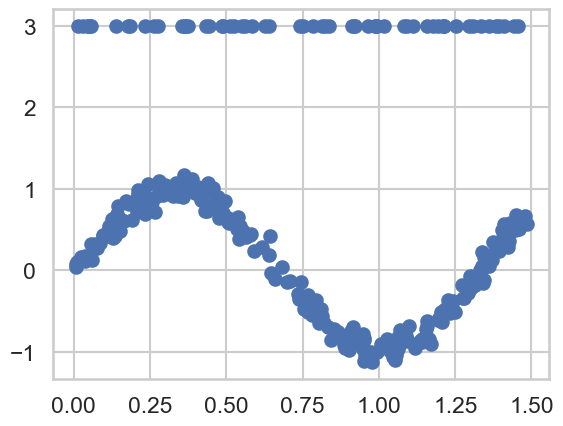

In [45]:
plt.scatter(X, y_errors)

**Задание**: Последовательно постройте различные модели для разных видов испорченности данных.

In [46]:
estimators = {
    "OLS": LinearRegression(),
    "Theil-Sen": TheilSenRegressor(random_state=42),
    "RANSAC": RANSACRegressor(random_state=42),
    "Huber": HuberRegressor(),
}

colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}
linestyle = {"OLS": "-", "Theil-Sen": "-.", "RANSAC": "--", "Huber": "--"}
lw = 2
fig, ax = plt.subplots(nrows=3, ncols=2, figsize= (12,8))
fig.tight_layout()
x_plot = np.linspace(X.min(), X.max())
time_dict = {name: 0. for name in estimators.keys()}
errors_df = pd.DataFrame(columns = list(estimators.keys()))
time_dict["Problem"] = "Sum time"
for i, (title, this_X, this_y) in enumerate([
    ("Modeling Errors Only", X, y),
    ("Corrupt X, Small Deviants", X_errors, y),
    ("Corrupt y, Small Deviants", X, y_errors),
    ("Corrupt X, Large Deviants", X_errors_large, y),
    ("Corrupt y, Large Deviants", X, y_errors_large),
]):
    ax[i % 3, i // 3].plot(this_X[:, 0], this_y, "b+")
    errors_dict = {"Problem": title}
    for name, estimator in estimators.items():
        model = # make_pipeline # Сделайте комбинацию полиномиальной регрессии и текущей модели. Используйте make_pipeline
        t0 = time.time()
        model.fit(this_X, this_y)
        time_dict[name] += time.time() - t0
        mse = # Посчитайте ошибку
        errors_dict[name] = [mse]
        y_plot = model.predict(x_plot[:, np.newaxis])
        ax[i % 3, i // 3].plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label="%s: error = %.3f" % (name, mse),
        )
    errors_df = pd.concat([errors_df,pd.DataFrame.from_dict(data=errors_dict)])
    ax[i % 3, i // 3].title.set_text(title)
errors_df = pd.concat([errors_df, pd.DataFrame(time_dict, index=[0])]) 
plt.show()

SyntaxError: invalid syntax (3184111104.py, line 32)

In [ ]:
colors = {
    "OLS": "turquoise",
    "Theil-Sen": "gold",
    "RANSAC": "lightgreen",
    "Huber": "black",
}

In [ ]:
errors_df

**Задание**: Поиграйте с этими датасетами и параметрами моделей. 
Ответьте на вопросы:
- При каких размерах датасетов лучше использовать каждый из алгоритмов
- При каких процентах выбросов и их значениях лучше использовать каждый из алгоритмов
- Влияет ли то, как распределены выбросы, на выбор метода
- Влияет ли отношение шума к сигналу на выбор алгоритма
- Какие алгоритмы более чувствительны к параметрам, какие менее
Для ответов покажите таблицы и/или графики

## Гетероскедастичность

- **Вопрос 1**: Что такое гетероскедастичность?
- **Вопрос 2**: Какие последствия гетероскедастичности - почему положение о гомоскедачности так важно? 
- **Вопрос 3**: Мы наблюдаем гетероскедастичсность. Предложите примеры гетероскедастичности. В каких  случаях это нарушение возникает из-за нарушения других положений? 

В этой части рассмотрим данные о стоимости домовладения. При этом будем использовать следующие признаки:
* Y = стоимость дома
* X1 = площадь дома
* X2 = площадь участка
Подмножество набора данных об исследовании американского сообщества, полученного из Бюро переписей США.

In [ ]:
data = pd.read_csv(f"{data_path}/realestate.txt", sep="\t") # pd.read_csv(f"{data_path}/realestate.csv").dropna()

In [ ]:
# Делаем доп.датасет со всеми положениями
linear_X, linear_y = datasets.make_regression(n_samples=data.shape[0],
                                              n_features=data.shape[1],
                                              noise=75, random_state=46)

# Setting feature names to x1, x2, x3, etc. if they are not defined
linear_feature_names = ['X'+str(feature+1) for feature in range(linear_X.shape[1])]

In [ ]:
data.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[["SqFeet"]], np.log(data["SalePrice"]))

Если провести регрессионный анализ и оценить график остатков в сравнении с предсказанными значениями, можно отметить несколько «коническую» форму остатков.

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
sns.scatterplot(x=preds, y=y_test, label="prediction")
plt.xlabel('Prediction of Y')
plt.ylabel('Y')
plt.legend()
plt.title(f'Predictions vs real value on test set')
plt.show()

In [ ]:
print(f"The score of prediction is: {model.score(X_test, y_test)}")

Другой способ построить график остатков предлагает Sklearn

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_train, y_pred=model.predict(X_train))
display.plot()
plt.show()

Более объективную оценку могут дать специальные статистические тесты, например, тест Уайта или тест Брейша-Пагана

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import statsmodels.stats.diagnostic as smd

Тест Бреуша-Пагана  можно выполнить с помощью функции het_breuschpagan модуля statsmodels.stats.diagnostic для оценки того, объясняют ли независимые переменные дисперсию ошибок. Основные параметры функции het_breuschpagan resid - остатки модели, а exog_het — независимые переменные. Обратите внимание, что ему нужна также константная переменная. 
Этот тест проверяет нулевую гипотезу о том, что все дисперсии ошибок равны, в сравнении с альтернативой, согласно которой дисперсии ошибок являются мультипликативной функцией одной или нескольких переменных. Этот тест затрагивает линейную форму гетероскедастичности.

Тест Уайта (het_white) оценивает то, объясняют ли независимые переменные линейной регрессии, квадратичные независимые переменные и перемножения независимых переменных дисперсию ошибок. Он не накладывает ограничений на форму гетероскедастичности.  Внутри происходит регрессия квадратов остатков по отношению к исодным переменным, их квадратам и попарным произведениям. Он более обзий как раз из-за добавления дополнительных переменных. Например, квадраты позволяют найти гетероскедастичность в форме "песочных часов". Однако, у него есть минус в том, что исходная гипотеза разбивается на несколько.

**Вопрос**: почему это минус? Укажите теоретическую причину.


Основные параметры в функции het_white resid - остатки, а exog - независимые переменные для объяснения дисперсии ошибок модели. 

Выполним тесты для нашего датасета, чтобы понять, реально ли в модели присутствует гетероскедастичность.

In [ ]:
def get_residual_df(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = df_results['Actual'] - df_results['Predicted']
    
    return df_results


In [ ]:
res_train = get_residual_df(model, X_train, y_train)
res_test = get_residual_df(model, X_test, y_test)

In [ ]:
X_test_new = X_test.copy()
X_test_new["const"]=1.

In [ ]:
bptest = smd.het_breuschpagan(resid=res_test["Residuals"], exog_het=X_test_new)
print("lm:", bptest[0], "lm_pvalue:", bptest[1])

**Вопрос**: что означает pvalue? Можем ли мы сказать, что остатки гетероскедачстичны?

In [ ]:
wtest = smd.het_white(resid=res_test["Residuals"], exog=X_test_new)
print("lm:", wtest[0], "lm_pvalue:", wtest[1])

### Решение проблемы
**Вопрос**: Как можно избавиться от гетероскедастичности (или уменьшить ее влияние)? 

Линейная модель описывается уравнением \begin{equation*} \textbf{Y}=\textbf{X}\beta+\epsilon^{*}, \end{equation*}
При этом $ \epsilon^{*} $ распределены нормально с нулевым средним и изменяющейся дисперсией:
\begin{equation*} \left(\begin{array}{cccc} \sigma^{2}_{1} & 0 & \ldots & 0 \\ 0 & \sigma^{2}_{2} & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \sigma^{2}_{n} \\ \end{array} \right) \end{equation*}
Тогда мы можем определить веса $ w_i = 1/\sigma^{2}_{i} $ так чтобы
\begin{equation*}\textbf{W}=\left( \begin{array}{cccc} w_{1} & 0 & \ldots & 0 \\ 0& w_{2} & \ldots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0& 0 & \ldots & w_{n} \\ \end{array} \right) \end{equation*}


Поскольку каждый вес обратно пропорционален дисперсии ошибки, он отражает информацию, содержащуюся в этом наблюдении. Итак, наблюдение с небольшой дисперсией ошибки имеет большой вес, поскольку оно содержит относительно больше информации, чем наблюдение с большой дисперсией ошибки (малый вес).
Веса должны быть известны (или, чаще всего, оценены) с точностью до константы пропорциональности.

Тогда можно поставить задачу взвешенной регрессиии \begin{equation*} \sum_{i=1}^n w_i^2(y_i - (\alpha 1 + \beta x_i))^2 = \sum_{i=1}^n (w_i y_i - (\alpha w_i + \beta w_i x_i))^2
\end{equation*}


Так как остатки в нашей задаче зависят от величины Y, мы можем предсказать их по этому признаку. Однако, наприямую мы это сделать не можем, так как 

**Задание**: Постройте взвешенную модель, учитывающую гетероскедастичность. Для построения весов используйте аппроксимацию ошибки.

In [ ]:
# force all estimates to be positive
add_y_train = # set up your approximation
add_y_test = # set up your approximation


In [ ]:
# Fit a regression model
sns.scatterplot(x=preds, y=y_test, label="residual value")
plt.xlabel('Prediction of Y')
plt.ylabel('Y')
plt.legend()
plt.title(f'Regression residuals on test set')
plt.show()

In [ ]:
weight_regressor = LinearRegression().fit(np.abs(X_train), add_y_train)
residual_estimates_train = weight_regressor.predict(np.abs(X_train))
residual_estimates_test = weight_regressor.predict(np.abs(X_test))
display = PredictionErrorDisplay(y_true=add_y_test, y_pred=residual_estimates_test)
display.plot()
plt.show()

In [ ]:
weights_train = # your code 
weights_test = # your code 

In [ ]:
updated_model = LinearRegression().fit(X_train, y_train, weights_train)
updated_preds = updated_model.predict(X_test)

In [ ]:
display = PredictionErrorDisplay(
    y_true=y_test, y_pred = updated_preds
    )
display.plot()
plt.show()

In [ ]:
print(f"The score of prediction is: {updated_model.score(X_test, y_test)}")

In [ ]:
X_test_new = X_test.copy()
X_test_new["const"]=1.

In [ ]:
bptest = smd.het_breuschpagan(resid=(y_test-updated_preds), exog_het=X_test_new)
print("lm:", bptest[0], "lm_pvalue:", bptest[1])

In [ ]:
wtest = smd.het_white(resid=(y_test-updated_preds), exog=X_test_new)
print("lm:", wtest[0], "lm_pvalue:", wtest[1])

In [ ]:
sns.scatterplot(x=X_test["SqFeet"], y=y_test, label='sale cost', color='blue')
# Постройте два графика моделей.
plt.xlabel('log(SqFeet)')
plt.ylabel('log(SalePrice)')
plt.legend()
plt.title(f'Use of weighted linear regression on data with heteroscedastic residuals')
plt.show()

В нашем случае остатки линейной регрессии симметричны, поэтому мы можем легко перейти на квантильную регрессиию, которая позволяет оценить заданные квантили таргета. Этот регрессор минимизирует MAE, в отличие от стандартной регрессии.

Вопрос: Почему он минимизирует MAE?


In [ ]:
from sklearn.linear_model import QuantileRegressor

In [ ]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions_test = np.zeros_like(y_test, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X_train, y_train).predict(X_test)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions_test = np.logical_or(
            out_bounds_predictions_test, y_pred >= y_test
        )
    elif quantile == max(quantiles):
        out_bounds_predictions_test = np.logical_or(
            out_bounds_predictions_test, y_pred <= y_test
        )

In [ ]:
for quantile, y_pred in predictions.items():
    plt.plot(X_test, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    X_test[out_bounds_predictions_test],
    y_test[out_bounds_predictions_test],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    X_test[~out_bounds_predictions_test],
    y_test[~out_bounds_predictions_test],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")


Почитать: https://www3.nd.edu/~rwilliam/stats2/l25.pdf

**Задание**: Постройте модели, учитывающие гетероскедастичность  для  Anscombe 3 и 4. Предложите сами, как вы будете задавать веса.

**Задание**: Постройте синтетические данные, подходящие для линейной модели. Покажите, поможет ли использование QuantileRegressor для удаления выбросов получить лучшую модель и для каких видов гетероскедастичности (выбросы, распределение, "форма" шума)

## Мультиколлинеарность

Мультиколлинеарность представляет собой проблему, поскольку она дает менее надежные результаты регрессионной модели. Это связано с более широкими доверительными интервалами (большими стандартными ошибками), которые могут снизить статистическую значимость коэффициентов регрессии. При анализе данных это может привести к ложным впечатлениям.

Рассмотрим уже знакомый нам набор данных, посвященный недвижимости.

In [ ]:
data = pd.read_csv(f"{data_path}/realestate.txt", sep="\t")

In [ ]:
data["SalePrice"] = np.log(data["SalePrice"])
data.describe()

Обучим базовую модель на одном признаке.

In [ ]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Теперь добавим несколько видов мультиколлинеарности в данных.

### Совершенная коллинеарность

Если две или более независимых переменных имеют между собой линейную связь, то
у нас получается идеальная мультиколлинеарность.
Примеры: включение одной и той же информации дважды (стоимость в рублях и долларах), неправильное использование фиктивных переменных (dummy variables trap) и т. д.
Вот пример идеальной мультиколлинеарности в модели с двумя объясняющими
переменными:
\begin{equation}
y = α_{1} X_1 + \alpha_{2} X_2
\end{equation}
\begin{equation}
X_1 = \beta_1 X_2 + \beta_2
\end{equation}


In [ ]:
data["SqFeet_changed"] = data["SqFeet"]* 0.8 + 10
corrplot(data)

In [ ]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

In [ ]:
data["SqFeet_changed_2"] = data["SqFeet"]* 0.5 - 10
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet_changed_2", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

По идее, совершенная коллинеарность не дает в принципе построить линейную модель, так как невозможно оценить маржинальный эффект воздействия признака на целевую переменную, сохраняя остальные константными.
)
На практике же, даже если конкретная реализация OLS позволит построить коэффициенты, это ведет к тому, что модель перестает быть устойчивой.

### Несовершенная мультиколлинеарность
Несовершенная мультиколлинеарность не нарушает базовых предположений ЛР. Следовательно, теорема Гаусса-Маркова говорит нам, что оценки МНК состоятельны.

Так почему же нас волнует мультиколлинеарность?
2. Дисперсия и стандартные ошибки оценок коэффициентов регрессии будут
увеличиваться. Это означает более низкую t-статистику.
3. На общую точность уравнения регрессии мультиколлинеарность практически не повлияет.
4. Коэффициенты регрессии будут сильно зависеть от признаков. Таким образом, коэффициенты существенно измениться при добавлении или удалении переменных.

In [ ]:
data["SqFeet_changed"] = data["SqFeet"] * 0.8 - 20
data["SqFeet_changed_2"] = data["SqFeet_changed"] * 1.5 + 10

data["SqFeet_changed"] += np.random.normal(+1, 0.5, len(data["SqFeet_changed"]))
data["SqFeet_changed_2"] += np.random.normal(-1, 0.5, len(data["SqFeet_changed"]))


In [ ]:
corrplot(data)

In [ ]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet_changed_2", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

In [ ]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[["SqFeet_changed", "SqFeet"]], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

Как видно, только один признак имеет большой вес, точность при этом практически не меняется. Однако значимость многих признаков становится неудовлетворительной. Поэтому, если оценить значимость коэффициентов модели, можно обнаружить, что многие признаки просто не нужны. При этом получается, что даже при очень небольшом изменении модели мы можем сделать совершенно противоположные выводы о том, какие признаки важны.

Итак, первый способ найти коллинеарные признаки - оценить значимость коэффициентов (t-statistic + p-value)

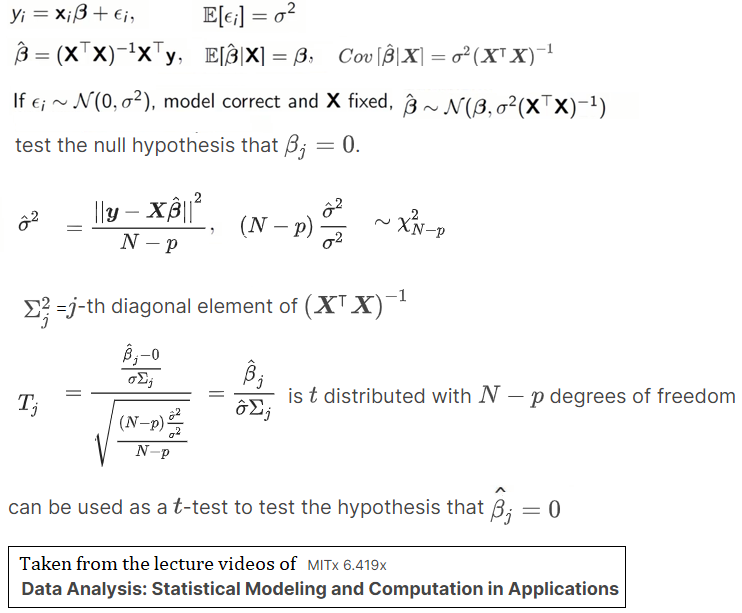

In [ ]:
from scipy.stats import t

In [ ]:
def get_p_values(model, x: pd.DataFrame, y: pd.DataFrame, a: int = 0.01) -> None:
  beta_hat = [model.intercept_] + model.coef_.tolist()
  n = len(x)
  print(f"Coeffficents: {beta_hat}")
  x_1 = np.column_stack((np.ones(n), x))
  # standard deviation of the noise.
  sigma_hat = # CAlculate the noise
  # estimate the covariance matrix for beta
  beta_cov = # Get (X^TX)^-1
  # the t-test statistic for each variable from the formula from above figure
  t_vals =  # your code: beta_hat / (sigma_hat * sqrt(diagonal(beta_cov)))
  # compute 2-sided p-values.
  p_vals = t.sf(np.abs(t_vals), n-x_1.shape[1])*2
  print(f"T values: {t_vals}")
  print(f"p-values: {p_vals}")
  print(f"Is valuable: {p_vals > 0.01}")

In [ ]:
get_p_values(model, x_test, y_test)

Мультиколлинеарность можно обнаружить и с помощью коэффициента инфляции дисперсии (VIF). Для каждого признака в построенной модели этот коэффициент покащзывает, в какой степени коэфициент "испорчен" коллинеарностью с другими признаками.

В методе VIF мы выбираем каждый признак и сравниваем его со всеми другими признаками. Для каждого признака коэффициент рассчитывается как:

image.png
где R-квадрат — коэффициент детерминации в линейной регрессии этого признака, построенной по всем остальным признакам (1-to-all). Его значение лежит между 0 и 1.
Как мы видим из формулы, чем больше значение R-квадрат, тем больше VIF. Следовательно, больший VIF означает большую корреляцию. Это согласуется с тем фактом, что более высокое значение R-квадрат означает более сильную коллинеарность. Обычно значение VIF выше 5 указывает на высокую мультиколлинеарность.


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [# calculating VIF for each feature]

print(vif_data)

Как мы видим, наши переменные имеют очень высокие значения VIF, что означает сильную коллинеарность между ними.


In [ ]:
features = ['SqFeet', 'Beds', 'Baths', 'Air', 'Garage', 'Pool', 'Year',
       'Quality', 'Style', 'Lot', 'Highway']

In [ ]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(data[features], data["SalePrice"], random_state=42)
model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f"Model score is: {model.score(x_test, y_test)}")
print(f"Coefficients are: {model.coef_}")

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [ # calculate VIF for each feature ]
vif_data

Теперь можно удалить некоторые признаки. Для этого используются разные способы feature selection. Посмотрим, узменится ли предсказание при удалении некоторых признаков

**Задание**: Постройте модель, удалив лишние признаки. Можно ли получить модель с лучшим скором?

In [ ]:
# Your code